# Beginner-Friendly Machine Learning Tutorial: Penguins Dataset

Welcome! This notebook will guide you step-by-step through a hands-on machine learning workflow using the Palmer Penguins dataset. You will learn how to:

- Load and explore data
- Preprocess and clean data
- Build and evaluate a machine learning model
- Visualize results

Let's get started!

In [1]:
# 1. Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 2. Setup: Import Libraries and Configure Environment

Let's import the necessary Python libraries and set up our environment.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from src.utility import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

## 3. About the Custom Machine Learning Classes

This notebook uses several custom classes from `utility.py` to simplify and enhance the machine learning workflow:

- **FeatureEngineeringSelector**: Flexible feature selection and engineering.
- **DataFramePreprocessor**: Handles missing values, scaling, encoding, and duplicate removal.
- **GraphAnalyzerEngine**: Analyzes feature importances and relationships.
- **VisualizerFactory**: Provides advanced visualizations.

These tools make the machine learning process more accessible and interpretable.

## 4. Load and Explore the Penguins Dataset

The Palmer Penguins dataset contains measurements for penguin species observed in Antarctica. Let's load the data and take a first look.

In [3]:
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
# Inspect the target variable
penguins['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

## 5. Data Preprocessing: Feature Selection and Cleaning

To prepare our data for machine learning, we need to:

- Separate features (inputs) from the target (output)
- Clean and preprocess the data (handle missing values, encode categories, etc.)

**Note:** The 'species' column is categorical and will be encoded. Other categorical columns include 'island' and 'sex'.

In [5]:
preproc = DataFramePreprocessor(
    fill_strategy='drop',  # Drop rows with missing values for simplicity
    encoding='label'
)
penguins_clean = preproc.fit_transform(penguins)
label_map = preproc.get_label_mapping()
print("Label Mapping:", label_map)
penguins_clean.head()

Label Mapping: {'species': {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}, 'island': {0: 'Biscoe', 1: 'Dream', 2: 'Torgersen'}, 'sex': {0: 'Female', 1: 'Male', 2: 'nan'}}


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1


## 6. Dataset Overview and Feature/Target Separation

Let's generate summary statistics and separate features (X) from the target (y).

In [6]:
overview = preproc.dataset_overview(penguins_clean)
print("Basic stats:\n", overview['stats'])
print("\nColinear pairs (correlation >= 0.8):", overview['colinear_pairs'])

# Separate features and target
X = penguins_clean.drop(columns=['species'])
y = penguins_clean['species']

Basic stats:
                         variance  unique_values  nan_counts    dtype
species                 0.791599              3           0    int32
island                  0.510818              3           0    int32
bill_length_mm         29.906333            163           0  float64
bill_depth_mm           3.877888             79           0  float64
flipper_length_mm     196.441677             54           0  float64
body_mass_g        648372.487699             93           0  float64
sex                     0.250733              2           0    int32

Colinear pairs (correlation >= 0.8): [('species', 'flipper_length_mm', 0.8507367840013593), ('flipper_length_mm', 'body_mass_g', 0.8729788985653616)]


## 7. Feature Engineering and Selection

We'll use a model-based strategy to select informative features.

In [7]:
strategies = [
    {
        "name": "model_importance",
        "model_cls": RandomForestClassifier,
        "threshold": "mean"
    }
]

fes = FeatureEngineeringSelector(
    strategies=strategies,
    problem_type='classification',
    random_state=42
)

X_transformed = fes.fit_transform(X, y)
print("✓ Selected features:", fes.get_support())
print("✓ Transformation history:")
for step in fes.get_history():
    print("  •", step)
print("✓ Transformed shape:", X_transformed.shape)
print("\nPreview of transformed features:")
X_transformed.head()

✓ Selected features: ['bill_length_mm', 'flipper_length_mm']
✓ Transformation history:
  • {'step': 'model_importance', 'selected': ['bill_length_mm', 'flipper_length_mm'], 'importances': [0.11052413828274918, 0.3484512763778806, 0.15294419675469964, 0.25838368289685737, 0.12072962056453324, 0.008967085123279983]}
✓ Transformed shape: (333, 2)

Preview of transformed features:


,bill_length_mm,flipper_length_mm
0,39.1,181.0
1,39.5,186.0
2,40.3,195.0
4,36.7,193.0
5,39.3,190.0


## 8. Model Training and Evaluation

Now, let's train a machine learning model to predict the penguin species. We'll:

- Split the data into training and test sets
- Train a Random Forest classifier
- Evaluate the model's performance using a classification report and confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        37
           1       0.85      1.00      0.92        17
           2       1.00      0.90      0.95        30

    accuracy                           0.95        84
   macro avg       0.94      0.96      0.95        84
weighted avg       0.96      0.95      0.95        84



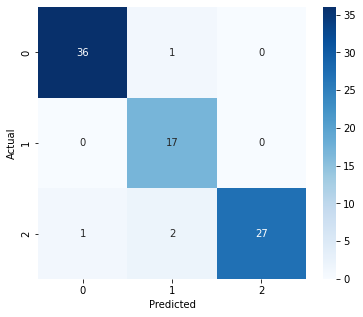

In [8]:
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42, stratify=y)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

## 9. Feature Importance and Visualization

Let's use advanced visualizations to explore feature importances and relationships.

In [9]:
engine = GraphAnalyzerEngine()
engine.analyze(X_transformed, pd.DataFrame(y))
store = engine.get_store()
# Relabel targets for better readability
relabel_targets_in_store(store, label_map.get('species', {}))
fig_sankey = VisualizerFactory.make_sankey(store, show_feature_feature_links=False)
fig_sankey.show()

### 10. Bar Plot of Feature Importances

The bar plot below shows the aggregated importance of each feature. The dashed line represents the threshold for random (noise) importance. Features above this line are considered informative.

In [10]:
fig_bar = VisualizerFactory.make_bar(store, show_threshold=True, show_noise=True)
fig_bar.show()

## 11. t-SNE Feature Visualization

Visualize the transformed features and classes using t-SNE.

In [11]:
fig_tsne = VisualizerFactory.make_tsne(X_transformed, y,
                                       label_map=label_map.get('species', {}),
                                       perplexity=10,
                                       random_state=42)
fig_tsne.show()

## 12. Conclusion and Next Steps

Congratulations! You have completed a full machine learning workflow on the Penguins dataset:

- Data loading and exploration
- Preprocessing and cleaning
- Model training and evaluation
- Feature importance analysis and visualization

Feel free to experiment with different models, parameters, or datasets!